In [2]:
import pretty_midi
import numpy as np

In [3]:
from __future__ import print_function

import pretty_midi
import numpy as np
# For plotting
import mir_eval.display
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline
# For putting audio in the notebook
import IPython.display
import fluidsynth

In [4]:
# Construct a PrettyMIDI object.
# We'll specify that it will have a tempo of 80bpm.
pm = pretty_midi.PrettyMIDI(initial_tempo=80)

In [5]:
print(pm.instruments)

[]


In [94]:
# Let's add a Cello instrument, which has program number 42.
# pretty_midi also keeps track of whether each instrument is a "drum" instrument or not
# because drum/non-drum instruments share program numbers in MIDI.
# You can also optionally give the instrument a name,
# which corresponds to the MIDI "instrument name" meta-event.
inst = pretty_midi.Instrument(program=42, is_drum=False, name='my cello')
pm.instruments.append(inst)

In [96]:
# Let's add a few notes to our instrument
velocity = 100
for pitch, start, end in zip([60, 62, 64], [0.2, 0.6, 1.0], [1.1, 1.7, 2.3]):
    inst.notes.append(pretty_midi.Note(velocity, pitch, start, end))
print(inst.notes)

[Note(start=0.200000, end=1.100000, pitch=60, velocity=100), Note(start=0.600000, end=1.700000, pitch=62, velocity=100), Note(start=1.000000, end=2.300000, pitch=64, velocity=100)]


In [98]:
# We'll just do a 1-semitone pitch ramp up
n_steps = 512
bend_range = 8192//2
for time, pitch in zip(np.linspace(1.5, 2.3, n_steps),
                       range(0, bend_range, bend_range//n_steps)):
    inst.pitch_bends.append(pretty_midi.PitchBend(pitch, time))

In [6]:
pretty_midi.note_number_to_hz(60)
pretty_midi.hz_to_note_number(261)

59.9585553965427

/var/folders/3m/gq6dpqj94vvd72cp8579k_fr0000gn/T/ipykernel_15846/2914792024.py:3: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  librosa.display.specshow(pm.get_piano_roll(fs)[start_pitch:end_pitch],


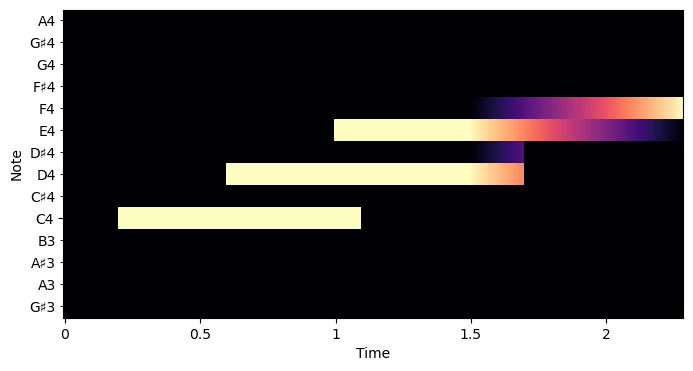

In [102]:
def plot_piano_roll(pm, start_pitch, end_pitch, fs=100):
    # Use librosa's specshow function for displaying the piano roll
    librosa.display.specshow(pm.get_piano_roll(fs)[start_pitch:end_pitch],
                             hop_length=1, sr=fs, x_axis='time', y_axis='cqt_note',
                             fmin=pretty_midi.note_number_to_hz(start_pitch))

plt.figure(figsize=(8, 4))
plot_piano_roll(pm, 56, 70)
# Note the blurry section between 1.5s and 2.3s - that's the pitch bending up!

In [104]:
# Synthesis frequency
fs = 48000
IPython.display.Audio(pm.synthesize(fs=48000), rate=48000)
# Sounds like sine waves...

In [106]:
IPython.display.Audio(pm.fluidsynth(fs=16000), rate=16000)
# Sounds (kind of) like a cello!

In [108]:
pm.write('out.mid')

In [110]:
# We'll load in the example.mid file distributed with pretty_midi
pm = pretty_midi.PrettyMIDI('example.mid')

/var/folders/3m/gq6dpqj94vvd72cp8579k_fr0000gn/T/ipykernel_15846/2914792024.py:3: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  librosa.display.specshow(pm.get_piano_roll(fs)[start_pitch:end_pitch],


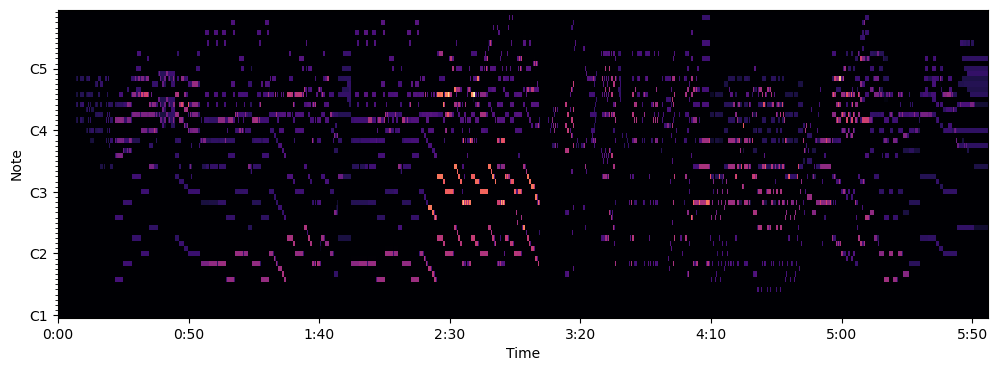

In [112]:
plt.figure(figsize=(12, 4))
plot_piano_roll(pm, 24, 84)

In [113]:
# Let's look at what's in this MIDI file
print('There are {} time signature changes'.format(len(pm.time_signature_changes)))
print('There are {} instruments'.format(len(pm.instruments)))
print('Instrument 1 has {} notes'.format(len(pm.instruments[0].notes)))
print('Instrument 4 has {} pitch bends'.format(len(pm.instruments[3].pitch_bends)))
print('Instrument 5 has {} control changes'.format(len(pm.instruments[4].control_changes)))

There are 12 time signature changes
There are 13 instruments
Instrument 1 has 888 notes
Instrument 4 has 60 pitch bends
Instrument 5 has 12 control changes


In [114]:
# What's the start time of the 10th note on the 3rd instrument?
print(pm.instruments[2].notes[10].start)
# What's that in ticks?
tick = pm.time_to_tick(pm.instruments[2].notes[10].start)
print(tick)
# Note we can also go in the opposite direction
print(pm.tick_to_time(int(tick)))

24.271851000000005
2688
24.271851000000005


In [115]:
# Let's shift the entire piece up by 2 semitones.
for instrument in pm.instruments:
    # Skip drum instruments - their notes aren't pitched!
    if instrument.is_drum:
        continue
    for note in instrument.notes:
        note.pitch += 2

In [116]:
# Get the length of the MIDI file
length = pm.get_end_time()
# This will effectively slow it down to 110% of its original length
pm.adjust_times([0, length], [0, length*1.1])
# Let's check what time our tick from above got mapped to - should be 1.1x
print(pm.tick_to_time(int(tick)))

26.699036100000004


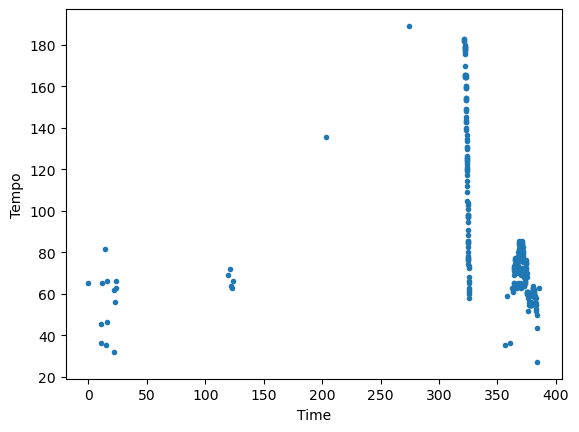

In [117]:
# Plot the tempo changes over time
# Many MIDI files won't have more than one tempo change event,
# but this particular file was transcribed to somewhat closely match the original song.
times, tempo_changes = pm.get_tempo_changes()
plt.plot(times, tempo_changes, '.')
plt.xlabel('Time')
plt.ylabel('Tempo');

In [123]:
# Get and downbeat times
beats = pm.get_beats()
downbeats = pm.get_downbeats()

/var/folders/3m/gq6dpqj94vvd72cp8579k_fr0000gn/T/ipykernel_15846/2914792024.py:3: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  librosa.display.specshow(pm.get_piano_roll(fs)[start_pitch:end_pitch],


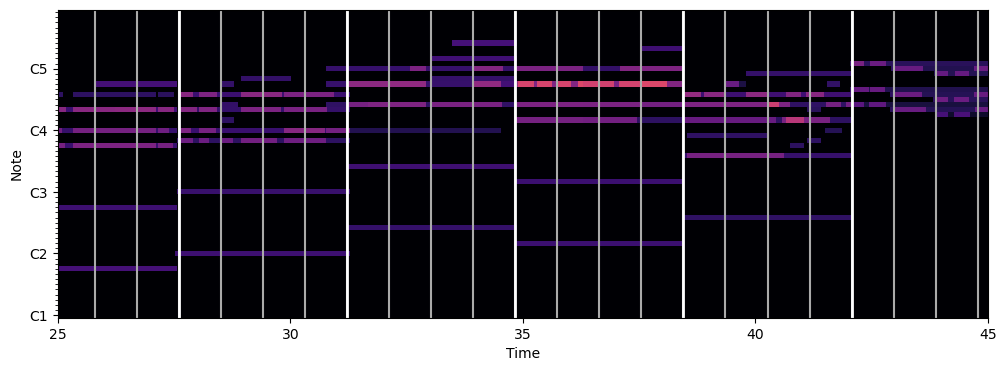

In [127]:
import matplotlib.pyplot as plt
import mir_eval.display

# Create a matplotlib figure and axis
fig, ax = plt.subplots(figsize=(12, 4))

# Plot piano roll
plot_piano_roll(pm, 24, 84)

# Get ymin and ymax for setting event lines
ymin, ymax = ax.get_ylim()

# Plot beats as grey lines
for beat in beats:
    ax.axvline(beat, color='#AAAAAA', linestyle='-')

# Plot downbeats as white lines
for downbeat in downbeats:
    ax.axvline(downbeat, color='#FFFFFF', linestyle='-', linewidth=2)

# Set xlim to display only 20 seconds
plt.xlim(25, 45)

# Show the plot
plt.show()


Text(0, 0.5, 'Proportion')

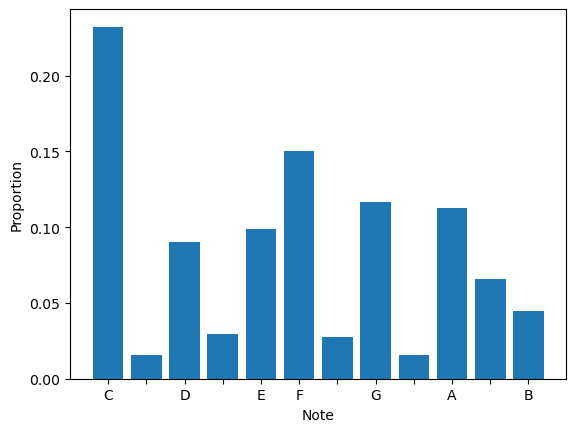

In [141]:
# Plot a pitch class distribution - sort of a proxy for key
plt.bar(np.arange(12), pm.get_pitch_class_histogram());
plt.xticks(np.arange(12), ['C', '', 'D', '', 'E', 'F', '', 'G', '', 'A', '', 'B'])
plt.xlabel('Note')
plt.ylabel('Proportion')

In [161]:
# Let's count the number of transitions from C to D in this song
n_c_to_d = 0
for instrument in pm.instruments:
    # Drum instrument notes don't have pitches!
    if instrument.is_drum:
        continue
    for first_note, second_note in zip(instrument.notes[:-1], instrument.notes[1:]):
        n_c_to_d += (first_note.pitch % 12 == 0) and (second_note.pitch % 12 == 2)
print('{} C-to-D transitions.'.format(n_c_to_d))

60 C-to-D transitions.


In [163]:
print('Program number 42 is {}'.format(pretty_midi.program_to_instrument_name(42)))
print('... and has instrument class {}'.format(pretty_midi.program_to_instrument_class(42)))
print('Bassoon has program number {}'.format(pretty_midi.instrument_name_to_program('Bassoon')))

Program number 42 is Cello
... and has instrument class Strings
Bassoon has program number 70


In [165]:
print('Splash Cymbal has note number {} on drum instruments'.format(
    pretty_midi.drum_name_to_note_number('Splash Cymbal')))

Splash Cymbal has note number 55 on drum instruments


In [167]:
print('A pitch bend value of 1000 is {:.3f} semitones'.format(
    pretty_midi.pitch_bend_to_semitones(1000)))
print('To pitch bend by -1.3 semitones, use the value {}'.format(
    pretty_midi.semitones_to_pitch_bend(-1.3)))

A pitch bend value of 1000 is 0.244 semitones
To pitch bend by -1.3 semitones, use the value -5324
